### Vorgehensweisen bei der Lösung von Aufgaben

#### Einführung

Am Beispiel der Aufgabe zur Glättung eines PGM-Bildes sollen hier unterschiedliche Herangehensweisen an die Lösung vorgestellt werden.

Zur Erinnerung:<br>
Gegeben ist ein PGM Graustufenbild
<center>

![cpp1_a7_dreifach.pgm](cpp1_a7_abb_7_1_dreifach.png)<br>
Abbildung 7.1.: Grauwertbild in der Datei `cpp1_a7_dreifach.pgm`
</center>

Zunächst wurden in der Aufgabe zwei Funktionen implementiert, die Graustufenbilder dieser Art in ein Dictionary einlesen und aus einem solchen Dictionary wieder in eine Datei schreiben können:

In [6]:
# Lösung 7.1. Bilddatei lesen und speichern
import os
import sys
from IPython.display import display,HTML
from PIL import Image

################################################################################
# Lesen eines PGM Image-Files in ein Dictionary.
# fileName: Pfad zur PGM-Image-Datei
# return  : dict['magic']: Magic der PGM-Datei
#           dict['width']: Breite des Bildes
#           dict['height']: Höhe des Bildes
#           dict['pixels']: Liste von Zeilen mit Liste von Pixeln in einer Zeile
################################################################################
def readPgmImageFile(fileName):
    if (not os.path.exists(fileName)):
        raise FileNotFoundError(f"Datei {fileName} existiert nicht!")
    if (not os.path.isfile(fileName)):
        raise FileNotFoundError(f"Datei {fileName} existiert, ist aber keine Datei!")
    
    image = dict()
    image['pixels']=[]
    itemCount=0
    rowIdx=0
    colIdx=0
    with open(fileName, 'r', encoding='ascii') as file:
            text = file.read()
    for item in text.split():
        if (itemCount==0):
            image['magic']=item
        elif (itemCount==1):
            image['width']=int(item)
        elif (itemCount==2):
            image['height']=int(item)
        elif (itemCount==3):
            image['maxgray']=int(item)
        else:
            # Zeilen-Liste ermitteln
            row = image['pixels'][rowIdx] if len(image['pixels']) > rowIdx else []
            
            # Zeilenumbruch
            if len(row) >= image['width']:
                rowIdx+=1
                colIdx=0
                row=[]
            # Pixelwert einfügen
            pixel = int(item)
            if (pixel < 0 or pixel > image['maxgray']):
                raise ValueError(f"Pixel[{rowIdx}][{colIdx}]Erwarte Pixel 0..{image['maxgray']}, ist aber {pixel}")
            
            row.append(int(item))
            colIdx+=1
            
            # Zeile anhängen, wenn neu
            if (len(row) == 1):
                image['pixels'].append(row)
        itemCount+=1
    return image # Rückgabe des mit den Bilddaten gefüllten Dictionaries.

################################################################################
# Schreiben eines PGM Image Dictionaries in eine Datei.
# image:    image['magic']: Magic der PGM-Datei
#           image['width']: Breite des Bildes
#           image['height']: Höhe des Bildes
#           image['pixels']: Liste von Zeilen mit Liste von Pixeln in einer Zeile
# fileName: Pfad zur PGM-Image-Datei
################################################################################
def writePgmImageFile(image, fileName):
    try:
        with open(fileName, 'w', encoding='ascii') as file:
            file.write(f"{image['magic']}\n")
            file.write(f"{image['width']}{image['height']:4d}\n")
            file.write(f"{image['maxgray']}\n")
            for row in image['pixels']:
                for pixel in row:
                    file.write(f"{pixel:4d} ")
                file.write("\n")
    except PermissionError as e:
        raise OSError(f"Rechte zum Schreiben der Datei {fileName} fehlen")
    except IOError as e:
        raise OSError(f"Fehler bei Schreiben der Datei {fileName}")
    

##### Beispiel: Glättung eines PGM-Bildes

Nach der Implementation des Einlesens und Wegschreibens wurden verschiedene Funktionen zur Bildbearbeitung implementiert.<br>
Eine davon war die Glättung:

Bei der Glättung entsteht das Zielpixel durch Mittelwertbildung über das Originalpixel und dessen 8 Umgebungspixel (Abbildung 7.3). Durch die Glättung werden harte Kontraste gemildert.
<center>

![Glättung](cpp1_a7_7_2_3_1_glaettung.png)<br>
Abbildung 7.2.3.1.: Glättung durch Mittelwertbildung über 9 Bildpunkte
</center>

Für die Glättung war eine passende Methode zu implementiere. Das Ergebnis sollte so aussehen:
<center>

![cpp1_a7_dreifach.pgm nach Glättung](cpp1_a7_7_2_3_2_glaettung.png)<br>
Abbildung 7.2.3.2: `cpp1_a7_dreifach.pgm` nach Glättung
</center>

Die Gefahr besteht, "mal irgendwie anzufangen" - am Besten mit dem Tippen und den Quellcode "wachsen zu lassen".

##### Vorgehen 1: Hart codierte Mittelwertbildung
Neben der Sonderbehandlung der äußeren Pixel des Bildes, mangels vollständiger Anzahl von 8 Nachbarpixel kein Mittelwert berechnet werden kann, ist die Ermittlung des Mittelwertes des Pixels und seiner 8 Nachbarpixel zentral. Dazu müssen die Werte des Pixels und der Nachbarpixel aufsummiert und durch 9 dividiert werden.

Eine erste Überlegung wäre, diesen Vorgang einfach hart zu codieren:



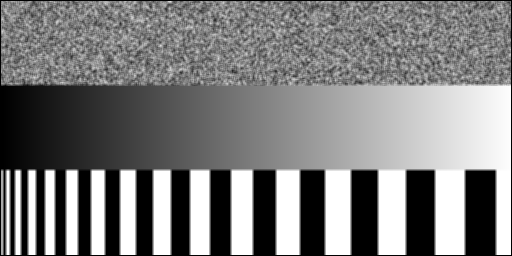

In [7]:
# Lösung Glaettung Vorgehen 1: Hart codierte Mittelwertbildung

################################################################################
# Glätten eines PGM Image Dictionaries
# image:    image['magic']: Magic der PGM-Datei
#           image['width']: Breite des Bildes
#           image['height']: Höhe des Bildes
#           image['pixels']: Liste von Zeilen mit Liste von Pixeln in einer Zeile
# return: Geglättete Version des übergebenen PGM Images in einem neuen Dictionary
################################################################################
def smoothedImage1(image):
    result = dict();

# Die Lösung ist wegen sich wiederholenden Codes nicht optimal.
    result['magic']   = image['magic']        # Das Magic aus der Datei ("P2").
    result['width']   = image['width']        # Breite des Bildes in Pixeln.
    result['height']  = image['height']       # Höhe des Bildes in Pixeln.
    result['maxgray'] = image['maxgray']      # Maximal vorkommender Grauwert.
    result['pixels']  = []                    # Die Pixel des Bildes. pixels ist eine Liste (von Zeilen),
    
    # Erste Zeile schwarz
    blackRow = []
    for x in range(0, image['width']):
        blackRow.append(0)
    result['pixels'].append(blackRow)

    for y in range(1, image['height']-1):
        newRow = []
        # Erster Spalte schwarz
        newRow.append(0)
        
        for x in range(1, image['width']-1):

            # 3 Pixel über dem Pixel mit den Koordinanten y und x:
            pixel = image['pixels'][y-1][x-1]
            pixel += image['pixels'][y-1][x]
            pixel += image['pixels'][y-1][x+1]
            
            # Pixel sowie Pixel links und rechts neben dem Pixel mit den Koordinanten y und x:
            pixel += image['pixels'][y][x-1]
            pixel += image['pixels'][y][x]
            pixel += image['pixels'][y][x+1]
            
            # 3 Pixel unter dem Pixel mit den Koordinanten y und x:
            pixel += image['pixels'][y+1][x-1]
            pixel += image['pixels'][y+1][x]
            pixel += image['pixels'][y+1][x+1]

            newRow.append(int(pixel/9))
            
        # Letzte Spalte schwarz
        newRow.append(0)
        result['pixels'].append(newRow)
    
    # Letzte Zeile schwarz durch Wiederverwendung der oben erzeugten schwarzen Zeile
    result['pixels'].append(blackRow)
    
    return result


###########################################################
# Test
###########################################################
try:
    infile="cpp1_a7_dreifach.pgm"
    outfile="smoothed.out1.pgm"

    image = readPgmImageFile(infile)
    processedImage = smoothedImage1(image)
    writePgmImageFile(processedImage, outfile)

    with Image.open(outfile) as i:
	    display(i)

except ValueError as e:
    sys.stderr.write(str(e))
except OSError as e:
    sys.stderr.write(str(e))
except Exception as e:
    sys.stderr.write("Unerwarteter Fehler:")
    sys.stderr.write(str(e))
    raise e
    

##### Vorgehen 2: Mittelwertbildung durch Schleifen

Die Lösung, die Mittelwertberechnung hart zu codieren ist nicht wirklich "smart", sondern Copy&Paste-Code mit veränderten Indizes.

Da die Pixel, deren Graustufen-Mittelwert zu berechnen sind, nebeneinander liegen, bietet es sich an, dies durch Schleifen zu realisieren. Zusätzlich zu den äußeren Schleifen, die über alle Zeilen und für jede Zeile über Spalten laufen, für die Mittelwerte berechenet werden können, werden die Pixel, deren Mittelwert berechnet werden sollen, durch die Iteration über Offset-Werte dx und dy, nacheinander die Werte -1, 0 und 1 annnehmen, addressiert.

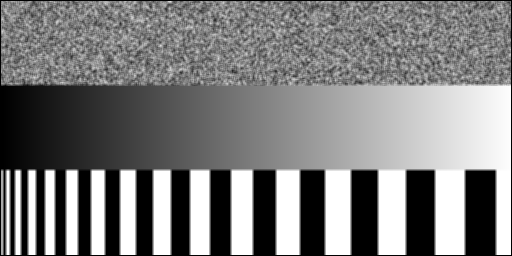

In [8]:
# Lösung Glaettung Vorgehen 2: Mittelwertbildung durch Schleifen

################################################################################
# Glätten eines PGM Image Dictionaries
# image:    image['magic']: Magic der PGM-Datei
#           image['width']: Breite des Bildes
#           image['height']: Höhe des Bildes
#           image['pixels']: Liste von Zeilen mit Liste von Pixeln in einer Zeile
# return: Geglättete Version des übergebenen PGM Images in einem neuen Dictionary
################################################################################
def smoothedImage2(image):
    result = dict();

# Die Lösung ist technisch besser, aber durch tiefe Verschachtelung (hier von Schleifen) unübersichtlich
    result['magic']   = image['magic']        # Das Magic aus der Datei ("P2").
    result['width']   = image['width']        # Breite des Bildes in Pixeln.
    result['height']  = image['height']       # Höhe des Bildes in Pixeln.
    result['maxgray'] = image['maxgray']      # Maximal vorkommender Grauwert.
    result['pixels']  = []                    # Die Pixel des Bildes. pixels ist eine Liste (von Zeilen),
    
    # Erste Zeile schwarz
    blackRow = []
    for x in range(0, image['width']):
        blackRow.append(0)
    result['pixels'].append(blackRow)
    
    for y in range(1, image['height']-1):
        newRow = []
        # Erster Spalte schwarz
        newRow.append(0)
        for x in range(1, image['width']-1):
            pixel = 0;
            for dy in [-1, 0, 1]:
                for dx in [-1, 0, 1]:
                    pixel += image['pixels'][y+dy][x+dx]
            newRow.append(int(pixel/9))
            
        # Letzte Spalte schwarz
        newRow.append(0)
        result['pixels'].append(newRow)
    
    # Letzte Zeile schwarz durch Wiederverwendung der oben erzeugten schwarzen Zeile
    result['pixels'].append(blackRow)
    
    return result


###########################################################
# Test
###########################################################
try:
    infile="cpp1_a7_dreifach.pgm"
    outfile="smoothed.out2.pgm"

    image = readPgmImageFile(infile)
    processedImage = smoothedImage2(image)
    writePgmImageFile(processedImage, outfile)

    with Image.open(outfile) as i:
	    display(i)

except ValueError as e:
    sys.stderr.write(str(e))
except OSError as e:
    sys.stderr.write(str(e))
except Exception as e:
    sys.stderr.write("Unerwarteter Fehler:")
    sys.stderr.write(str(e))
    raise e
    


##### Vorgehen 3: Teilaufgaben in einzelnen Methoden lösen

Die Lösung, die Mittelwertberechnung durch innere Schleifen zu berechnen, ist schon deutlich besser. Leider wird dies durch ein neues Problem "erkauft": Übersichtlich ist so ein Code mit vier verschachtelten Schleifen nicht gerade.

Derartig "verschwurbelten" Code übersichtlich zu gestalten (ein wichtiges Ziel bei jeder Softwareentwicklung), erfordert zusätzlichen Aufwand durch "Redesign".<br>
Nachträglich wird festgestellt, welche unabhängigen Aufgaben zu erledigen sind. Diese werden anschließend in eigenen Funktionen realisiert:

* Erstellen des Ergebnis-Bildes durch Anlegen eines Dictionaries mit den Metadaten des Ursprungsbildes.
* Zufügen einer schwarzen Zeile in das Ergebnis-Dictonary.
* Berechnung des Mittelwertes eines Pixes mit gegebenen Koordinaten aus dem Dictionary des Ursprungsbildes.
* Nochmaliges Zufügen einer schwarzen Zeile im Ergebnis-Dictionary.
* Speicher des Ergebnis-Dictionary in einer Ausgabedatei.

Das Lesen aus und Speichern in eine Datei sind bereits realisiert. Daher beschränkt sich die Lösung auf die reine Bildbearbeitung.

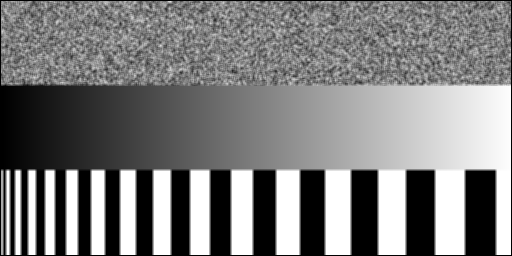

In [9]:
# Lösung Glaettung Vorgehen 3: Teilaufgaben in einzelnen Methoden lösen

################################################################################
# Erstellen eines neue Dictionary und Initialisieren mit den Metadaten eines 
# übergebenen Dictionary mit den Daten einer PGM Bilddatei entsprechend dem 
# folgenden Format. 
# image:    image['magic']: Magic der PGM-Datei
#           image['width']: Breite des Bildes
#           image['height']: Höhe des Bildes
#           image['pixels']: Liste von Zeilen mit Liste von Pixeln in einer Zeile
# return:   Neues Dictionary. 
#           Alle Metadaten des Parameter image werden übernommen. 
#           Ausnahme: ['pixels'] wird als leere Liste zurückgegeben
################################################################################
def createResultDict(image):
    result = dict();
    result['magic']   = image['magic']        # Das Magic aus der Datei ("P2").
    result['width']   = image['width']        # Breite des Bildes in Pixeln.
    result['height']  = image['height']       # Höhe des Bildes in Pixeln.
    result['maxgray'] = image['maxgray']      # Maximal vorkommender Grauwert.
    result['pixels']  = []                    # Die Pixel des Bildes. pixels ist eine Liste (von Zeilen),
    return result

################################################################################
# Erzeugen einer Liste mit schwarzen Pixeln (Graustufenwert 0) mit der Länge der
# Breite des übergebenen Dictionary mit den Daten einer PGM Bilddatei entsprechend 
# dem folgenden Format. 
# image:    image['magic']: Magic der PGM-Datei
#           image['width']: Breite des Bildes
#           image['height']: Höhe des Bildes
#           image['pixels']: Liste von Zeilen mit Liste von Pixeln in einer Zeile
# return:   Liste mit int(0) Werten. Anzahl der int-Werte: image['width'] 
################################################################################
def createBlackRow(image):
    blackRow = []
    for x in range(0, image['width']):
        blackRow.append(0)
    return blackRow

################################################################################
# Berechnet den Mittelwert des Pixels mit den Koordinaten y und y aus dem 
# Graustufenwert des Pixels sowie der 8 Nachbarpixel des übergebenen Dictionary 
# mit den Daten einer PGM Bilddatei entsprechend dem folgenden Format. 
# image:    image['magic']: Magic der PGM-Datei
#           image['width']: Breite des Bildes
#           image['height']: Höhe des Bildes
#           image['pixels']: Liste von Zeilen mit Liste von Pixeln in einer Zeile
# return:   Liste mit int(0) Werten. Anzahl der int-Werte: image['width'] 
################################################################################
def meanValueAt(image, y, x):
    pixel = 0;
    for dy in [-1, 0, 1]:
        for dx in [-1, 0, 1]:
            pixel += image['pixels'][y+dy][x+dx]
    return int(pixel/9)

################################################################################
# Glätten eines PGM Image Dictionaries
# image:    image['magic']: Magic der PGM-Datei
#           image['width']: Breite des Bildes
#           image['height']: Höhe des Bildes
#           image['pixels']: Liste von Zeilen mit Liste von Pixeln in einer Zeile
# return: Geglättete Version des übergebenen PGM Images in einem neuen Dictionary
################################################################################
def smoothedImage3(image):
    result = createResultDict(image)
    
    # Erste Zeile schwarz
    result['pixels'].append(createBlackRow(image))
    
    for y in range(1, image['height']-1):
        newRow = []
        # Erster Spalte schwarz
        newRow.append(0)
        for x in range(1, image['width']-1):
            newRow.append(meanValueAt(image, y, x))
            
        # Letzte Spalte schwarz
        newRow.append(0)
        result['pixels'].append(newRow)
    
    # Letzte Zeile schwarz
    result['pixels'].append(createBlackRow(image))
    
    return result


###########################################################
# Test
###########################################################
try:
    infile="cpp1_a7_dreifach.pgm"
    outfile="smoothed.out3.pgm"

    image = readPgmImageFile(infile)
    processedImage = smoothedImage3(image)
    writePgmImageFile(processedImage, outfile)

    with Image.open(outfile) as i:
	    display(i)

except ValueError as e:
    sys.stderr.write(str(e))
except OSError as e:
    sys.stderr.write(str(e))
except Exception as e:
    sys.stderr.write("Unerwarteter Fehler:")
    sys.stderr.write(str(e))
    raise e
    

##### Fazit

Durch die Aufteilung der einzelnen Problemstellungen / Teilaufgaben in Funktionen wird der Code viel übersichtlicher.

**Das hätte man von Anfang an haben können!**<br>
Noch besser ist es, es gar nicht erst zu einem solch "verschwurbelten" Code kommen zu lassen.<br>
Vielmehr gilt es, bereits beim Ansatz der Lösung 
* die Teilaufgaben zu identifizieren,
* Teilaufgaben zunächst als "leere" Funktionen (mit einem `pass` Befehl) zu implementieren und so im Überblick die Lösung zu planen.
* Ist das Vorgehen in der Hauptfunktion klar, werden die Methoden zur Lösung der Teilaufgaben unabhängig vom Ganzen implementiert.

<u>Vorteile</u>
* Die Übersichtlichkeit verhindert, beim Vorgang der Problemlösung den Faden zu verlieren.
* Dies führt zu einem schnelleren Entwicklungsfortschritt und
* verhindert, dass ein ein undurchschaubarer Code verworfen werden muss, weil ein Fehler nicht gefunden werden kann.
* Außerdem können die Funktionen unabhängig voneinander auf korrekte Funktion getestet werden.

<u>Tipp</u><br>
Wenn Sie eine Teilaufgabe und damit eine nötige Funktion identifiziert haben, **beginnen Sie mit dem Kommentar zur Funktion**!<br>
Die Notwendigkeit, den genauen Zweck der Funktion formulieren (was geht 'rein, was passiert, was geht 'raus) zu müssen, sorgt für Klarheit und verhindert Fehlentwicklungen durch unklare Vorstellungen vom Lösungsweg!

**Wenn Sie nicht formulieren können, was Sie programmieren wollen, brauchen Sie das Programmieren selbst gar nicht erst zu beginnen!**